## Imports

In [37]:
import pickle
import pandas as pd
from preprocessing import *
from feature_extraction import *
from SVM_pipeline import SVM_Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Preprocessing
For data pre-processing, make sure datasets are extracted into the 'datasets' directory in the project root. The structure should be: \
`datasets/1 December 2017 Dataset/*.dat`

In [ ]:
dataset_dir = 'datasets'
datasets_batches = get_dataset_batches(dataset_dir)

spectrograms_MTI = []
labels = []

for batch in datasets_batches:
    files = get_dataset_files(dataset_dir, batch)
    for i, file in enumerate(files):
        if 'Copy' in file or '(' in file:
            print(f'{batch} | [{i + 1}/{len(files)}]: {file} ignored for unrecognized file name.')
            continue

        t = time.time()
        dataset_file_path = os.path.join(dataset_dir, batch, file)
        person, activity, repetition = get_labels(file)
        Data_spec_MTI, velocity_axis, time_axis = preprocess_file(dataset_file_path, th_type='triangle', plot_range_mti=False, plot_spec_mti=False)

        spectrograms_MTI.append((Data_spec_MTI, velocity_axis, time_axis))
        # Only interested in activity
        labels.append(activity)

        print(f'{batch} | [{i + 1}/{len(files)}]: {file} in {time.time() - t:.2f} seconds. Activity: {activity}.')

os.makedirs('preprocessed_data', exist_ok=True)
with open(os.path.join('preprocessed_data', 'spectrograms.pkl'), 'wb') as f:
    pickle.dump((spectrograms_MTI, np.array(labels)), f)

## Load pre-processed data
```
spectrograms_MTI:     list of (2D array, 1D array, 1D array)
labels:               1D array of integers
```

In [4]:
with open(os.path.join('preprocessed_data', 'spectrograms.pkl'), 'rb') as f:
    # Each item in spectrograms_MTI is (spec, velocity_axis, time_axis)
    denoised_spectrograms_MTI, labels = pickle.load(f)

    # Option 1: Extract into separate lists
    spectrograms = [i[0] for i in denoised_spectrograms_MTI]
    velocity_axes = [i[1] for i in denoised_spectrograms_MTI]
    time_axes = [i[2] for i in denoised_spectrograms_MTI]

In [5]:
# Option 2: Loop through each item
for idx, (spectrogram, velocity_axis, time_axis) in enumerate(denoised_spectrograms_MTI):
    # Apply thresholding algorithm to spectrograms and update them in place
    spectrograms[idx][:] = denoise_spectrogram_per_timebin_basis(spectrogram)

## Feature extraction

Extract features from spectrograms and save the features to a file

In [22]:
features = []
for spectrogram, velocity_axis, time_axis, label in zip(spectrograms, velocity_axes, time_axes, labels):
    feature = feature_extraction(spectrogram, velocity_axis, time_axis)
    feature['label'] = label # Add label to the feature dictionary
    features.append(feature)

features_df = pd.DataFrame(features) # Save the features as a DataFrame
features_df.to_csv('preprocessed_data/features.csv', index=False)

If features.csv already exists, read the data from the preprocessed_data/features.csv

In [27]:
features_df = pd.read_csv('preprocessed_data/features.csv')
# Display the first few rows of the DataFrame
print(features_df.head())


   normalized_std    period    offset  bandwidth  bandwidth_wo_uD  \
0        6.432582  0.007176  2.655047   6.336207         0.387931   
1        6.349219  0.008637  2.879363   6.530172         0.387931   
2        6.448082  0.007667  2.956903   7.209052         0.840517   
3        6.299860  0.008058  2.317865   6.336207         0.355603   
4        6.343054  0.008981  2.336319   6.239224         0.355603   

   torso frequency  label  
0         0.184541      1  
1        -0.161012      1  
2        -0.138900      1  
3         0.075662      1  
4         0.039248      1  


## Machine Learning Pipeline

In [49]:
import importlib
import SVM_pipeline
importlib.reload(SVM_pipeline)
from SVM_pipeline import SVM_Pipeline

Initialize pipeline and split data

In [39]:
random_state = 42                                                               # Repeatable random state for reproducibility
split_ratio = 0.2                                                               # Ratio of the dataset to be used for testing
n_splits = 5                                                                    # Number of splits for cross-validation
n_features = features_df.shape[1] - 1                                           # Number of features (exclude the label column from the feature count)
svm_pipeline = SVM_Pipeline(n_splits=n_splits, random_state=random_state)       # Instantiate the SVM pipeline

# Split the data into training and test sets
X_train, X_test, y_train, y_test = svm_pipeline.init_and_split_data(features_df, split_ratio=split_ratio, random_state=random_state)

# Define parameter search space for SVM hyperparameters
param_grid = {
        'scaler' : [StandardScaler(), MinMaxScaler(), None],
        'sfs__k_features': [n_features], # Select all features but we will learn imporant features during the pipeline
        'svm__C': [0.1, 1, 10],
        'svm__kernel': ['linear', 'rbf'],
        'svm__gamma': ['scale', 'auto']
}
svm_pipeline.set_param_grid(param_grid)                                         # Set the parameter grid for hyperparameter tuning

Starting with SFS, conduct grid search using 5-fold cross validation for each combination SFS uses

In [41]:
# Conduct hyperparameter tuning using grid search
svm_pipeline.run_grid_search(X_train, y_train, scoring="f1_macro")
svm_pipeline.show_grid_search_results()

c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Aybar\anaconda3\envs\python-12\Lib\site-pa

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                       ('sfs',
                                        SequentialFeatureSelector(cv=0,
                                                                  estimator=SVC(),
                                                                  n_jobs=-1,
                                                                  scoring='accuracy')),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(), None],
                         'sfs__k_features': [6], 'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf']},
             scoring='f1_macro')

In [42]:
svm_pipeline.show_grid_search_results()

                                               params  mean_test_score  \
0   {'scaler': StandardScaler(), 'sfs__k_features'...         0.771823   
1   {'scaler': StandardScaler(), 'sfs__k_features'...         0.736377   
2   {'scaler': StandardScaler(), 'sfs__k_features'...         0.771823   
3   {'scaler': StandardScaler(), 'sfs__k_features'...         0.736377   
4   {'scaler': StandardScaler(), 'sfs__k_features'...         0.779242   
5   {'scaler': StandardScaler(), 'sfs__k_features'...         0.787940   
6   {'scaler': StandardScaler(), 'sfs__k_features'...         0.779242   
7   {'scaler': StandardScaler(), 'sfs__k_features'...         0.787940   
8   {'scaler': StandardScaler(), 'sfs__k_features'...         0.782937   
9   {'scaler': StandardScaler(), 'sfs__k_features'...         0.796334   
10  {'scaler': StandardScaler(), 'sfs__k_features'...         0.782937   
11  {'scaler': StandardScaler(), 'sfs__k_features'...         0.796334   
12  {'scaler': MinMaxScaler(), 'sfs__k

,params,mean_test_score,std_test_score,rank_test_score
0,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.771823,0.023617,15
1,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.736377,0.027451,20
2,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.771823,0.023617,15
3,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.736377,0.027451,20
4,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.779242,0.025643,8
5,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.787940,0.029434,4
6,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.779242,0.025643,8
7,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.787940,0.029434,4
8,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.782937,0.017304,6
9,"{'scaler': StandardScaler(), 'sfs__k_features'...",0.796334,0.018076,1


Best params: {'scaler': StandardScaler(), 'sfs__k_features': 6, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


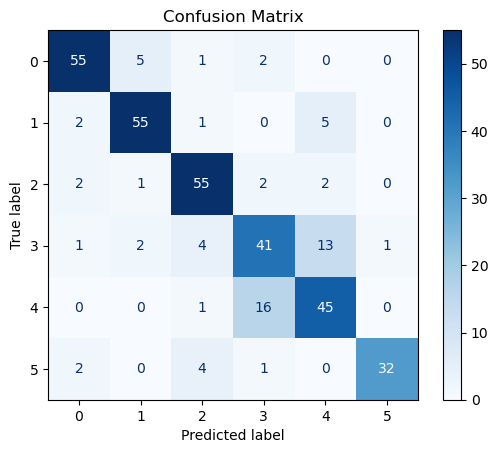

In [52]:
# Evaluate the best model on the test set
report = svm_pipeline.evaluate_model(X_test, y_test)

I will remove this part, somehow function above does not plot two things -Aybars

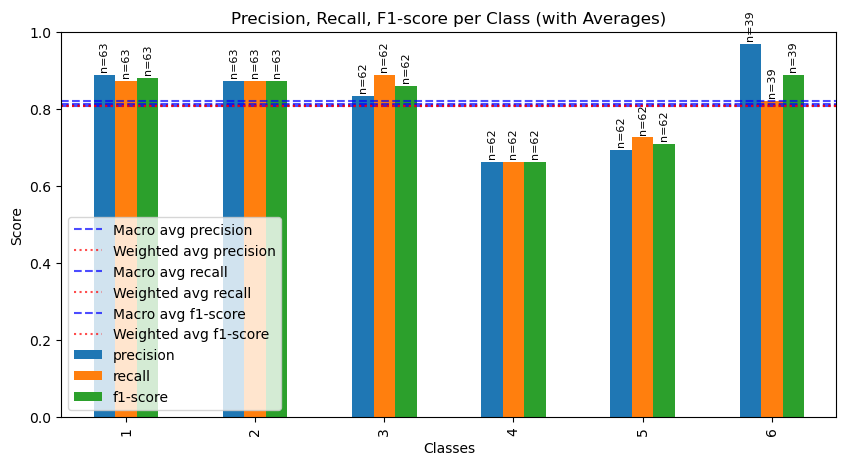

In [59]:
report_df = pd.DataFrame(report).transpose()
metrics = ['precision', 'recall', 'f1-score']
# Plot per-class metrics
ax = report_df.iloc[:-3, :-1][metrics].plot(kind='bar', figsize=(10, 5))

# Add macro and weighted averages as horizontal lines
for metric in metrics:
    macro_avg = report_df.loc['macro avg', metric]
    weighted_avg = report_df.loc['weighted avg', metric]
    ax.axhline(macro_avg, linestyle='--', color='blue', alpha=0.7, label=f'Macro avg {metric}')
    ax.axhline(weighted_avg, linestyle=':', color='red', alpha=0.7, label=f'Weighted avg {metric}')

# Annotate each bar with support
supports = report_df.iloc[:-3]['support']
for idx, support in enumerate(supports):
    for bar in ax.containers:
        height = bar[idx].get_height()
        ax.annotate(f'n={int(support)}', 
                    (bar[idx].get_x() + bar[idx].get_width() / 2, height + 0.01),
                    ha='center', va='bottom', fontsize=8, rotation=90)

plt.title("Precision, Recall, F1-score per Class (with Averages)")
plt.ylabel("Score")
plt.xlabel("Classes")
plt.ylim(0, 1)
plt.legend()
plt.show()

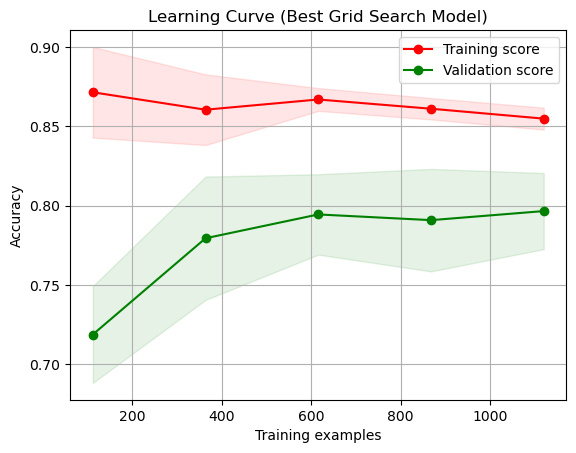

In [44]:
# Plot learning curve to check overfitting
svm_pipeline.plot_learning_curve(X_train, y_train)